# Deep learning

In [1]:
import tasks.data
import tasks.torch_train_eval

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics


import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output"

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_TEST_SPLIT = 0.3
TARGET_DATASET = "dslr"

RANDOM_SEED = 42
BATCH_SIZE = 3

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import imageio.v2 as imageio
from torchvision.transforms import v2


def resnet_preprocessor(image: np.ndarray) -> np.ndarray:
    """
    Preprocesses an image for ResNet model.

    :param numpy.ndarray image: The input image.
    :return: Preprocessed image.
    :rtype: numpy.ndarray
    """
    preprocess = torchvision.transforms.Compose(
        [    
            v2.ToImage(),
            #v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
            #v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
            v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
            #v2.ToTensor(),
            v2.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

    image = preprocess(image)
    return image


def image_read_func(image_path):
    return imageio.imread(image_path, pilmode='RGB')


In [3]:
source_dataset = tasks.data.ImageDataset(
    os.path.join(DATA_DIR, SOURCE_DATASET),
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)

source_train_loader, source_val_loader, source_test_loader = (
    tasks.data.train_val_test_loaders(
        source_dataset, BATCH_SIZE, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT, tasks.data.collate_pad
    )
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [4]:
import pickle


def try_load_weights(model, weights_path: str):
    try:
        model.load_state_dict(torch.load(weights_path))
    except Exception as e:
        print("Cannot load proper weights: ", e)
    return model


def try_load_history(history_path):
    try:
        with open(history_path, 'rb') as handle:
            history = pickle.load(handle)
    except:
        print("No history found in path ", history_path)
        history = None

    return history

In [5]:
import torchinfo


output_path = os.path.join(OUTPUT_DIR, SOURCE_DATASET)

model = torch.hub.load(
    "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
).to(device)
model = try_load_weights(model, os.path.join(output_path, "model.pt"))

torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [3, 1000]                 --
├─Conv2d: 1-1                            [3, 64, 150, 150]         9,408
├─BatchNorm2d: 1-2                       [3, 64, 150, 150]         128
├─ReLU: 1-3                              [3, 64, 150, 150]         --
├─MaxPool2d: 1-4                         [3, 64, 75, 75]           --
├─Sequential: 1-5                        [3, 64, 75, 75]           --
│    └─BasicBlock: 2-1                   [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-2             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-3                    [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-5             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-6                    [3, 64, 75, 75]           --
│

In [6]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)
# disable lr for adam
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.05)
previous_history = try_load_history(os.path.join(output_path, "history.pickle"))

train = False

if train:
    model, history = tasks.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=output_path,
        num_epochs=200,
        patience=12,
        warmup_period=100,
        previous_history=previous_history
    )
else:
    history = previous_history

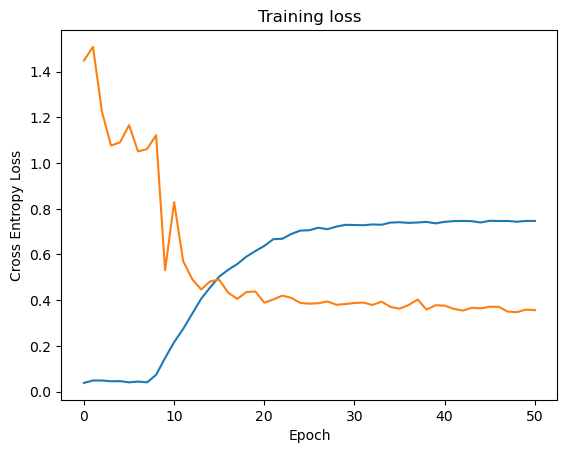

In [7]:
plt.plot(np.array(range(len(history["train_loss"]))), history["train_loss"])
plt.plot(np.array(range(len(history["val_loss"]))), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training loss")
plt.show()

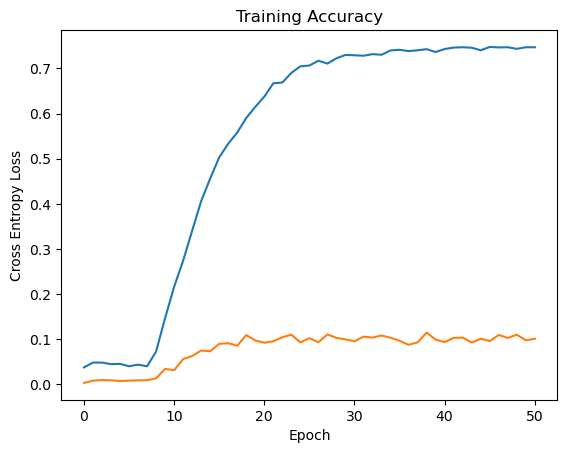

In [8]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [9]:
source_actual, source_predicted = tasks.torch_train_eval.test(model, source_test_loader, device)
class_names = source_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        source_actual, source_predicted, zero_division=0, target_names=class_names
    )
)

  0%|          | 0/94 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       1.00      0.67      0.80         9
            bike       1.00      1.00      1.00         8
     bike_helmet       1.00      0.88      0.93         8
        bookcase       0.78      0.88      0.82         8
          bottle       0.00      0.00      0.00         3
      calculator       0.86      0.75      0.80         8
      desk_chair       1.00      1.00      1.00         7
       desk_lamp       0.88      0.54      0.67        13
desktop_computer       0.75      0.67      0.71         9
    file_cabinet       1.00      0.43      0.60        14
      headphones       1.00      0.71      0.83        14
        keyboard       0.91      0.91      0.91        11
 laptop_computer       1.00      0.64      0.78        11
     letter_tray       0.88      0.78      0.82         9
    mobile_phone       0.87      0.87      0.87        15
         monitor       1.00      0.78      0.88         9
           mo

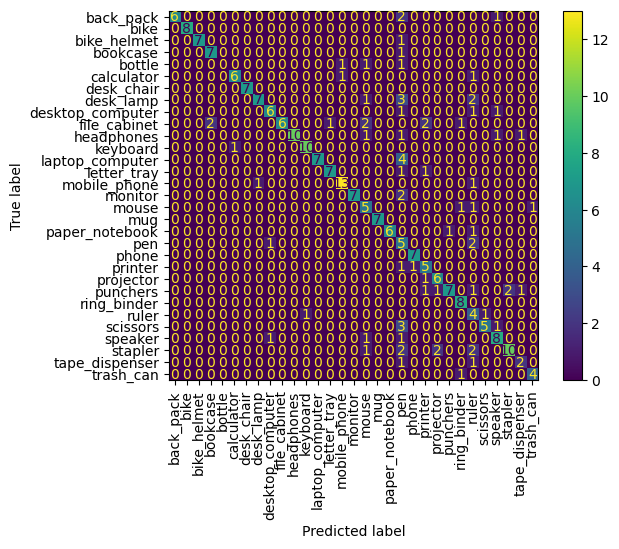

In [10]:
source_cf_matrix = sklearn.metrics.confusion_matrix(source_actual, source_predicted)
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=source_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

In [11]:
target_dataset = tasks.data.ImageDataset(
    os.path.join(DATA_DIR, TARGET_DATASET),
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
    label_encoder=source_dataset.label_encoder # use same classes
)

target_train_loader, target_val_loader, target_test_loader = (
    tasks.data.train_val_test_loaders(
        target_dataset, BATCH_SIZE, 0, TARGET_TEST_SPLIT, tasks.data.collate_pad
    )
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [12]:
target_actual, target_predicted = tasks.torch_train_eval.test(model, target_test_loader, device)
class_names = target_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        target_actual,
        target_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/50 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.00      0.00      0.00         5
            bike       0.00      0.00      0.00         6
     bike_helmet       0.50      0.14      0.22         7
        bookcase       0.00      0.00      0.00         7
          bottle       0.00      0.00      0.00         4
      calculator       0.00      0.00      0.00         5
      desk_chair       0.00      0.00      0.00         3
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.33      0.43      0.38         7
    file_cabinet       0.00      0.00      0.00         1
      headphones       0.00      0.00      0.00         3
        keyboard       0.00      0.00      0.00         0
 laptop_computer       0.40      0.33      0.36         6
     letter_tray       0.05      0.25      0.08         4
    mobile_phone       0.00      0.00      0.00         6
         monitor       0.00      0.00      0.00         6
           mo

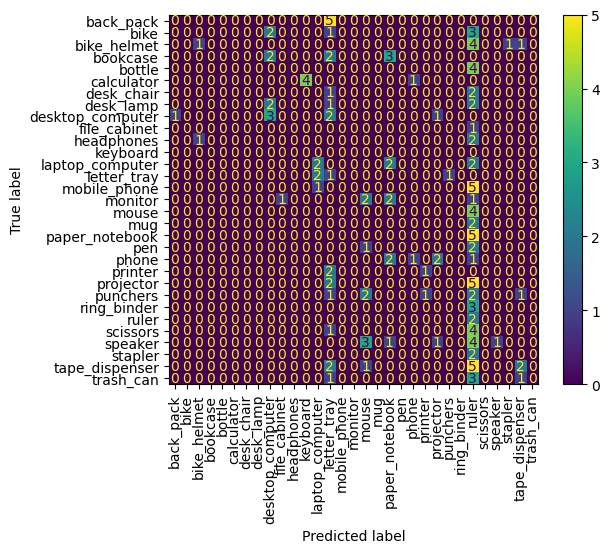

In [13]:
target_cf_matrix = sklearn.metrics.confusion_matrix(target_actual, target_predicted)
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=target_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

In [14]:
# code from https://towardsdatascience.com/neural-network-calibration-using-pytorch-c44b7221a61
def T_scaling(logits, temperature):
    return torch.div(logits, temperature)


temperature = nn.Parameter(torch.ones(1).cuda())
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []

for i, data in enumerate(tqdm(val_loader, 0)):
    images, labels = data[0].to(device), data[1].to(device)

    net.eval()
    with torch.no_grad():
      logits_list.append(net(images))
      labels_list.append(labels)

# Create tensors
logits_list = torch.cat(logits_list).to(device)
labels_list = torch.cat(labels_list).to(device)

def _eval():
  loss = criterion(T_scaling(logits_list, temperature), labels_list)
  loss.backward()
  return loss

optimizer.step(_eval)

NameError: name 'val_loader' is not defined